# Linear Regression from Scratch: Boston Housing Dataset

This notebook implements a complete linear regression model from scratch to predict the median value of homes (`medv`) in the Boston housing dataset. We will not use `scikit-learn` or any other ML library for the core model.

**Steps we will follow:**
1.  **Import Libraries:** `numpy`, `pandas`, `matplotlib`, `seaborn`.
2.  **Load Data:** Read the `Boston.csv` file.
3.  **EDA & Cleaning:** Explore the data, check for nulls, and visualize relationships.
4.  **Preprocessing:** Scale the features (critical for gradient descent) and split into training and testing sets.
5.  **Build Model:** Create a `LinearRegressionScratch` class.
6.  **Train Model:** Use gradient descent to find the optimal model parameters.
7.  **Evaluate Model:** Check the model's performance on the test set using Mean Squared Error (MSE) and R-squared.
8.  **Hypothesis Testing:** Check the statistical significance of the model (F-test) and its coefficients (t-test).
9.  **Visualize Results:** Plot predictions vs. actual values.

### Step 1: Import Libraries

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # Added for hypothesis testing

%matplotlib inline

# Set plot style
sns.set(style='whitegrid', context='talk')

### Step 2: Load Data

In [32]:
# Load the dataset. 
# The CSV has an unnamed index column, so we use index_col=0 to fix it.
try:
    df = pd.read_csv('Boston.csv', index_col=0)
    print("File loaded successfully!")
except FileNotFoundError:
    print("Error: Boston.csv not found. Please make sure the file is in the same directory.")
    # Create a placeholder empty dataframe to avoid errors later in the notebook
    df = pd.DataFrame()

if not df.empty:
    print("Data Head:")
    print(df.head())

File loaded successfully!
Data Head:
      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
1  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
2  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
3  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
4  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
5  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

    black  lstat  medv  
1  396.90   4.98  24.0  
2  396.90   9.14  21.6  
3  392.83   4.03  34.7  
4  394.63   2.94  33.4  
5  396.90   5.33  36.2  


### Step 3: Exploratory Data Analysis (EDA) & Cleaning

In [33]:
if not df.empty:
    # Get a summary of the data
    print("\nData Info:")
    df.info()

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
    # This dataset is famously clean - no missing values.


Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 506 entries, 1 to 506
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 59.3 KB

Missing Values:
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64


In [34]:
if not df.empty:
    # Get statistical summary
    print("\nData Description:")
    print(df.describe())


Data Description:
             crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       black  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     

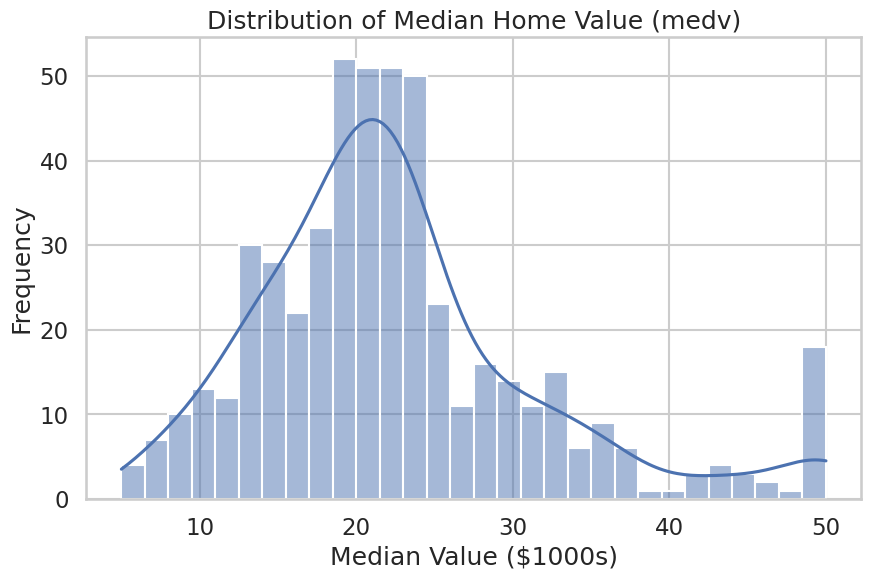

In [37]:
if not df.empty:
    # Visualize the distribution of the target variable 'medv'
    plt.figure(figsize=(10, 6))
    sns.histplot(df['medv'], bins=30, kde=True)
    plt.title('Distribution of Median Home Value (medv)')
    plt.xlabel('Median Value ($1000s)')
    plt.ylabel('Frequency')
    plt.show()

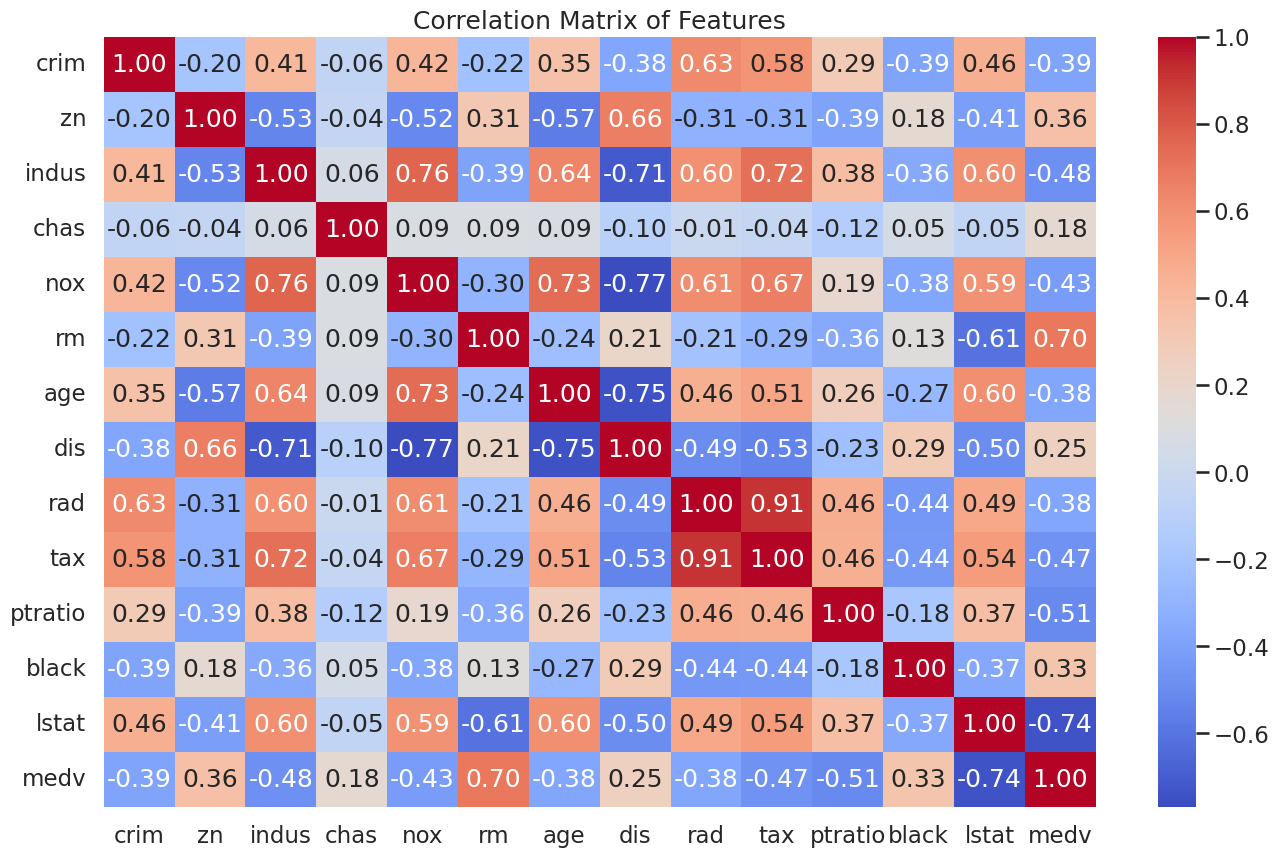

In [38]:
if not df.empty:
    # Visualize correlations
    # We want to see which features are most correlated with 'medv'
    plt.figure(figsize=(16, 10))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix of Features')
    plt.show()

**EDA Observations:**
* `medv` (our target) has a strong negative correlation with `LSTAT` (-0.74).
* `medv` has a strong positive correlation with `RM` (0.70).
* This means as `LSTAT` (% lower status of the population) goes up, `medv` goes down.
* As `RM` (avg. number of rooms) goes up, `medv` goes up.
* This makes intuitive sense and confirms these are good predictors.

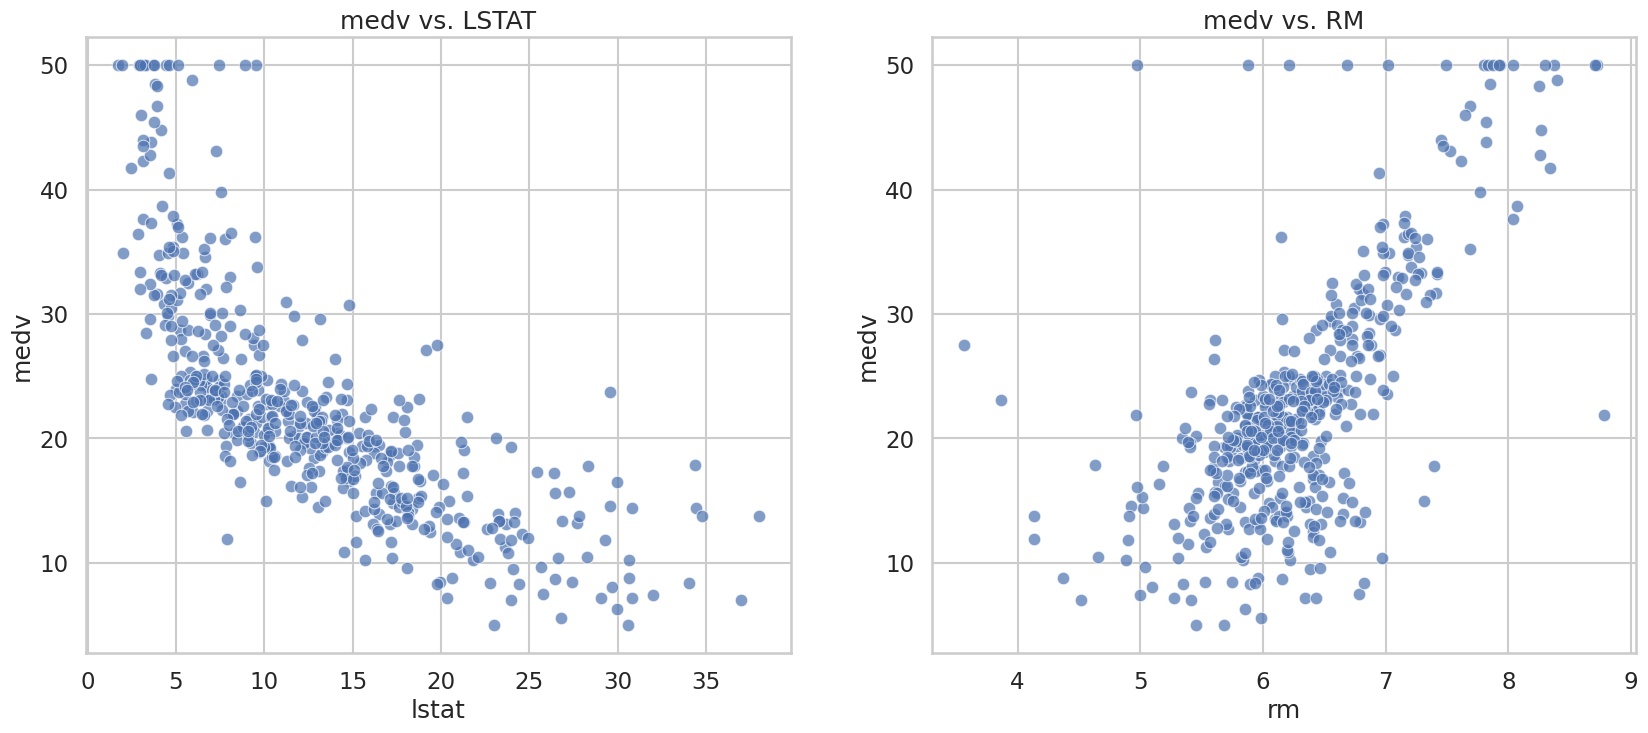

In [39]:
if not df.empty:
    # Scatter plot for the two strongest predictors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # LSTAT vs medv
    sns.scatterplot(x='lstat', y='medv', data=df, ax=ax1, alpha=0.7)
    ax1.set_title('medv vs. LSTAT')

    # RM vs medv
    sns.scatterplot(x='rm', y='medv', data=df, ax=ax2, alpha=0.7)
    ax2.set_title('medv vs. RM')

    plt.show()

### Step 4: Data Preprocessing

1.  **Separate Features (X) and Target (y):** `medv` is our y.
2.  **Feature Scaling:** We must scale our features. Gradient descent converges much faster and more reliably when features are on a similar scale. We'll use **Standardization** (Z-score normalization).
3.  **Add Bias Term:** We need to add a column of ones (`x0`) to our feature matrix `X`. This allows our weight vector to include the bias/intercept term.
4.  **Train-Test Split:** We'll create a simple function to split our data.

In [40]:
def preprocess_data(df, target_col, test_size=0.2):
    """Prepares the data for the model.
    
    1. Separates X and y.
    2. Standardizes X.
    3. Adds a bias column (x0=1) to X.
    4. Performs a train-test split.
    """
    if df.empty:
        return None, None, None, None, None
    
    # 1. Separate X and y
    y = df[target_col].values
    X_df = df.drop(target_col, axis=1)
    X = X_df.values
    
    # Get feature names
    feature_names = ['Intercept'] + list(X_df.columns)
    
    # 2. Standardize X
    # (X - mean) / std_dev
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_scaled = (X - X_mean) / X_std
    
    # 3. Add bias term (column of ones)
    # np.ones((X_scaled.shape[0], 1)) creates a column vector of ones
    # np.hstack stacks arrays horizontally
    X_final = np.hstack((np.ones((X_scaled.shape[0], 1)), X_scaled))
    
    # 4. Train-Test Split
    # First, shuffle the data to ensure random splitting
    indices = np.arange(X_final.shape[0])
    np.random.shuffle(indices)
    
    X_final = X_final[indices]
    y = y[indices]
    
    split_index = int((1 - test_size) * X_final.shape[0])
    
    X_train = X_final[:split_index]
    y_train = y[:split_index]
    X_test = X_final[split_index:]
    y_test = y[split_index:]
    
    return X_train, y_train, X_test, y_test, feature_names

In [41]:
if not df.empty:
    # Set a random seed for reproducibility
    np.random.seed(42)
    
    X_train, y_train, X_test, y_test, feature_names = preprocess_data(df, target_col='medv', test_size=0.2)
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"\nFeature Names (Total: {len(feature_names)}):")
    print(feature_names)
    
    # Check the first row of X_train to see the bias term (1.)
    print("\nFirst row of X_train (with bias):")
    print(X_train[0])

X_train shape: (404, 14)
y_train shape: (404,)
X_test shape: (102, 14)
y_test shape: (102,)

Feature Names (Total: 14):
['Intercept', 'crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat']

First row of X_train (with bias):
[ 1.         -0.40983668 -0.48772236 -1.03402724 -0.27259857 -0.38609067
  0.18715116  0.55208139 -0.54607682 -0.52300145 -0.66660821 -0.85792914
  0.42570183 -0.50645674]


### Step 5: Build Linear Regression Model (from scratch)

We will build a class that encapsulates the model's logic.

**Key Formulas:**
1.  **Hypothesis (Prediction):**
    `y_hat = h(X) = X · θ`
    (where `X` includes the bias term `x0=1` and `θ` is the vector of weights/coefficients)

2.  **Cost Function (Mean Squared Error):**
    `J(θ) = (1 / 2m) * Σ( (h(X_i) - y_i)^2 )`
    (We use 1/2m to simplify the gradient calculation)

3.  **Gradient (Partial Derivative of J w.r.t. θ):**
    `dJ/dθ = (1 / m) * X.T · (X · θ - y)`

4.  **Gradient Descent Update Rule:**
    `θ = θ - α * (dJ/dθ)`
    (where `α` is the learning rate)

In [42]:
class LinearRegressionScratch:
    """Linear Regression model implementation from scratch using Gradient Descent."""
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None  # This will store our weights (including bias)
        self.cost_history = [] # To visualize learning

    def fit(self, X, y):
        """Trains the model using Gradient Descent."""
        
        # m = number of samples, n = number of features (including bias)
        m_samples, n_features = X.shape
        
        # 1. Initialize weights (theta) to zero
        self.theta = np.zeros(n_features)
        self.cost_history = []
        
        for _ in range(self.n_iterations):
            # 2. Calculate hypothesis (predictions)
            # y_pred = X.dot(theta)
            y_pred = np.dot(X, self.theta)
            
            # 3. Calculate error
            error = y_pred - y
            
            # 4. Calculate gradient
            # gradient = (1 / m) * X.T.dot(error)
            gradient = (1 / m_samples) * np.dot(X.T, error)
            
            # 5. Update weights (theta)
            self.theta = self.theta - self.learning_rate * gradient
            
            # Store cost for this iteration
            cost = self.compute_cost(X, y, y_pred)
            self.cost_history.append(cost)
            
        print("Model training complete.")

    def predict(self, X):
        """Makes predictions for new data X."""
        if self.theta is None:
            raise Exception("Model not trained yet. Call fit() first.")
        
        # y_pred = X.dot(theta)
        return np.dot(X, self.theta)

    def compute_cost(self, X, y, y_pred):
        """Calculates the Mean Squared Error cost."""
        m_samples = X.shape[0]
        # J(θ) = (1 / 2m) * Σ(error^2)
        cost = (1 / (2 * m_samples)) * np.sum((y_pred - y)**2)
        return cost


### Step 6: Train & Evaluate Model

First, we need our evaluation metrics, also from scratch.

1.  **Mean Squared Error (MSE):** `(1 / m) * Σ( (y_true - y_pred)^2 )`
2.  **R-squared (R²):** `1 - (SS_res / SS_tot)`
    * `SS_res` (Sum of Squares of Residuals): `Σ( (y_true - y_pred)^2 )`
    * `SS_tot` (Total Sum of Squares): `Σ( (y_true - y_mean)^2 )`

In [43]:
def mean_squared_error(y_true, y_pred):
    """Calculates Mean Squared Error from scratch."""
    return np.mean((y_true - y_pred)**2)

def r2_score(y_true, y_pred):
    """Calculates R-squared (Coefficient of Determination) from scratch."""
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    
    # Check for ss_tot == 0 to avoid division by zero
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
        
    return 1 - (ss_res / ss_tot)

In [44]:
if 'X_train' in locals():
    # --- Train the Model ---
    
    # Hyperparameters
    learning_rate = 0.01
    n_iterations = 2000 # Increased iterations for better convergence

    model = LinearRegressionScratch(learning_rate=learning_rate, n_iterations=n_iterations)
    model.fit(X_train, y_train)
    
    # --- Evaluate the Model ---
    # We will evaluate on the *training* data for hypothesis testing
    # to see which features the model *learned* were important.
    y_pred_train = model.predict(X_train)
    
    mse_train = mean_squared_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    
    print("\n--- Model Evaluation (on Training Data) ---")
    print(f"Training Mean Squared Error (MSE): {mse_train:.2f}")
    print(f"Training R-squared (R²): {r2_train:.4f}")

    # --- Evaluation on Test Data ---
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("\n--- Model Evaluation (on Test Data) ---")
    print(f"Test Mean Squared Error (MSE): {mse_test:.2f}")
    print(f"Test R-squared (R²): {r2_test:.4f}")

else:
    print("Data not loaded, skipping model training.")


Model training complete.

--- Model Evaluation (on Training Data) ---
Training Mean Squared Error (MSE): 22.00
Training R-squared (R²): 0.7493

--- Model Evaluation (on Test Data) ---
Test Mean Squared Error (MSE): 22.13
Test R-squared (R²): 0.6892


### Step 7: Hypothesis Testing

Now we'll conduct hypothesis tests to check:
1.  **Overall Model Significance (F-test):**
    * $H_0$: All coefficients are zero (model is useless).
    * $H_a$: At least one coefficient is non-zero (model has predictive power).
2.  **Individual Coefficient Significance (t-test):**
    * $H_0$: $\theta_j = 0$ (feature *j* is not significant).
    * $H_a$: $\theta_j \neq 0$ (feature *j* is significant).

We will perform these calculations from scratch using our trained model and training data.

In [45]:
def perform_hypothesis_tests(model, X, y, feature_names):
    """Calculates t-statistics and F-statistic for the trained model."""
    
    print("--- Starting Hypothesis Tests ---")
    
    y_pred = model.predict(X)
    n_samples, n_features = X.shape # n = samples, p = features (incl. intercept)
    
    # --- T-Tests for Individual Coefficients ---
    
    # 1. Calculate residuals
    residuals = y - y_pred
    
    # 2. Calculate residual sum of squares (RSS or SS_res)
    ss_res = np.sum(residuals**2)
    
    # 3. Calculate residual standard error (RSE) or sigma_hat^2
    # This is the (MSE) of the regression
    df_residual = n_samples - n_features
    sigma_squared = ss_res / df_residual
    
    # 4. Calculate the covariance matrix of parameters
    # Var(theta) = sigma^2 * (X.T @ X)^-1
    try:
        X_T_X_inv = np.linalg.inv(X.T @ X)
        var_theta = sigma_squared * X_T_X_inv
    
        # 5. Get standard errors (SE) for each coefficient (sqrt of diagonal)
        se_theta = np.sqrt(np.diag(var_theta))
        
        # 6. Calculate t-statistics
        t_stats = model.theta / se_theta
        
        # 7. Calculate p-values (two-tailed test)
        # We use stats.t.sf (survival function) which is 1 - cdf
        p_values_t = stats.t.sf(np.abs(t_stats), df=df_residual) * 2
        
        # --- Format T-Test Results ---
        results_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': model.theta,
            'Std. Error': se_theta,
            't-statistic': t_stats,
            'p-value': p_values_t
        })
        print("\n--- T-Test Results (Individual Coefficients) ---")
        print(results_df.to_string())
        print("\n(p-value < 0.05 generally indicates a significant feature)")

    except np.linalg.LinAlgError:
        print("Error: Could not compute (X.T @ X)^-1. Matrix is singular.")
        print("This can be caused by perfect multicollinearity.")

    # --- F-Test for Overall Model Significance ---
    
    # 1. Calculate total sum of squares (SS_tot)
    y_mean = np.mean(y)
    ss_tot = np.sum((y - y_mean)**2)
    
    # 2. Calculate regression sum of squares (SS_reg)
    ss_reg = ss_tot - ss_res
    
    # 3. Define degrees of freedom
    df_regression = n_features - 1 # (p - 1)
    # df_residual is already defined (n - p)
    
    # 4. Calculate Mean Square Regression (MSR) and Mean Square Error (MSE)
    msr = ss_reg / df_regression
    mse = ss_res / df_residual # This is the same as sigma_squared
    
    # 5. Calculate F-statistic
    if mse == 0:
        print("\n--- F-Test Results ---")
        print("MSE is zero, F-statistic is undefined (perfect fit).")
    else:
        f_statistic = msr / mse
        
        # 6. Calculate p-value for F-statistic
        p_value_f = stats.f.sf(f_statistic, dfn=df_regression, dfd=df_residual)
        
        print("\n--- F-Test Results (Overall Model Significance) ---")
        print(f"F-statistic: {f_statistic:.2f}")
        print(f"p-value: {p_value_f}")
        if p_value_f < 0.05:
            print("Result: p-value is < 0.05. We REJECT the null hypothesis.")
            print("The model is statistically significant.")
        else:
            print("Result: p-value is >= 0.05. We FAIL to reject the null hypothesis.")
            print("The model is not statistically significant.")

# Run the tests using the training data (which the model was fit on)
if 'model' in locals():
    perform_hypothesis_tests(model, X_train, y_train, feature_names)
else:
    print("Model not trained, skipping hypothesis tests.")


--- Starting Hypothesis Tests ---

--- T-Test Results (Individual Coefficients) ---
      Feature  Coefficient  Std. Error  t-statistic        p-value
0   Intercept    22.604808    0.237894    95.020566  8.765055e-272
1        crim    -0.847694    0.295315    -2.870477   4.321869e-03
2          zn     1.136813    0.353103     3.219495   1.391729e-03
3       indus    -0.385194    0.483606    -0.796505   4.262231e-01
4        chas     0.620898    0.248541     2.498170   1.289452e-02
5         nox    -1.913358    0.490511    -3.900747   1.129167e-04
6          rm     2.582119    0.318781     8.099979   7.121417e-15
7         age     0.253852    0.424185     0.598446   5.498897e-01
8         dis    -3.211332    0.466197    -6.888351   2.272373e-11
9         rad     2.227782    0.651348     3.420264   6.916835e-04
10        tax    -1.739922    0.724584    -2.401270   1.680562e-02
11    ptratio    -1.939860    0.321735    -6.029375   3.820152e-09
12      black     0.786441    0.274314     2.

### Step 8: Visualize Results

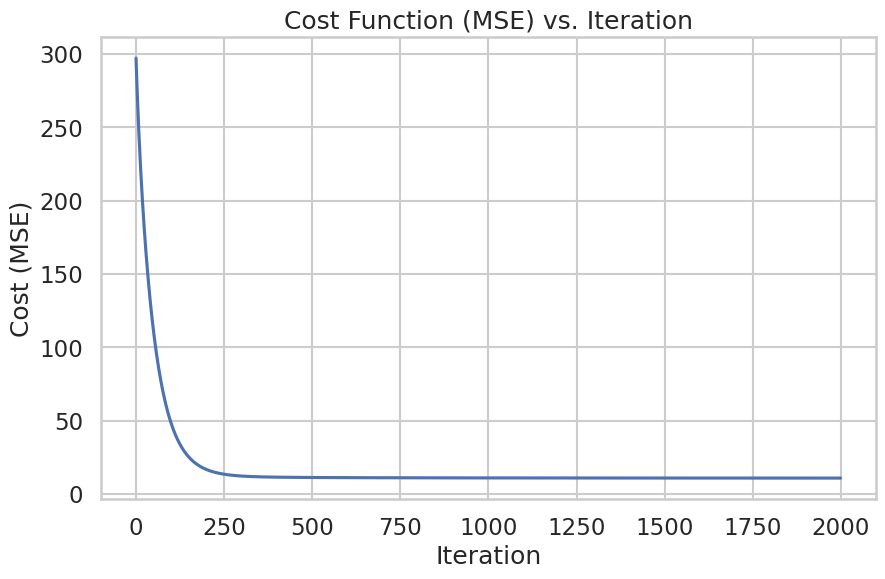

In [46]:
if 'model' in locals():
    # Plotting the Cost History (learning curve)
    plt.figure(figsize=(10, 6))
    plt.plot(range(model.n_iterations), model.cost_history)
    plt.title('Cost Function (MSE) vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Cost (MSE)')
    plt.show()
    
    # The cost drops dramatically and then flattens, which means our model converged!

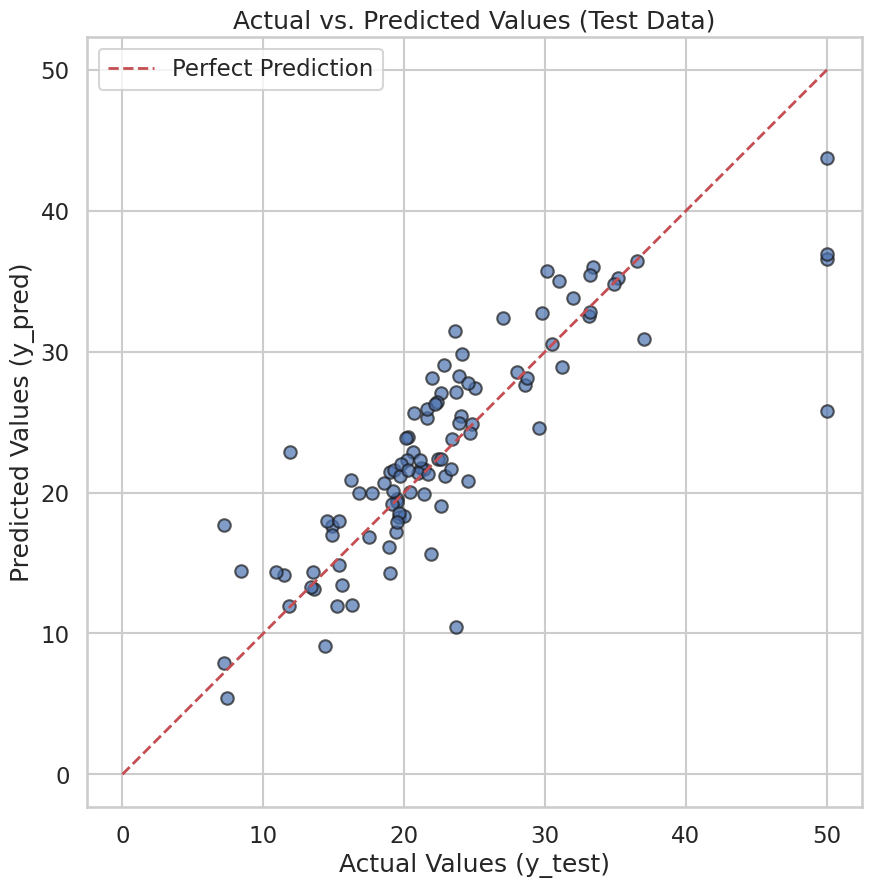

In [47]:
if 'model' in locals():
    # Plotting Predictions vs. Actual Values (on Test Data)
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='k')
    
    # Add the 'perfect prediction' line (y=x)
    line_max = max(np.max(y_test), np.max(y_pred_test))
    plt.plot([0, line_max], [0, line_max], 'r--', lw=2, label='Perfect Prediction')
    
    plt.title('Actual vs. Predicted Values (Test Data)')
    plt.xlabel('Actual Values (y_test)')
    plt.ylabel('Predicted Values (y_pred)')
    plt.legend()
    plt.axis('equal') # Set equal scaling
    plt.show()

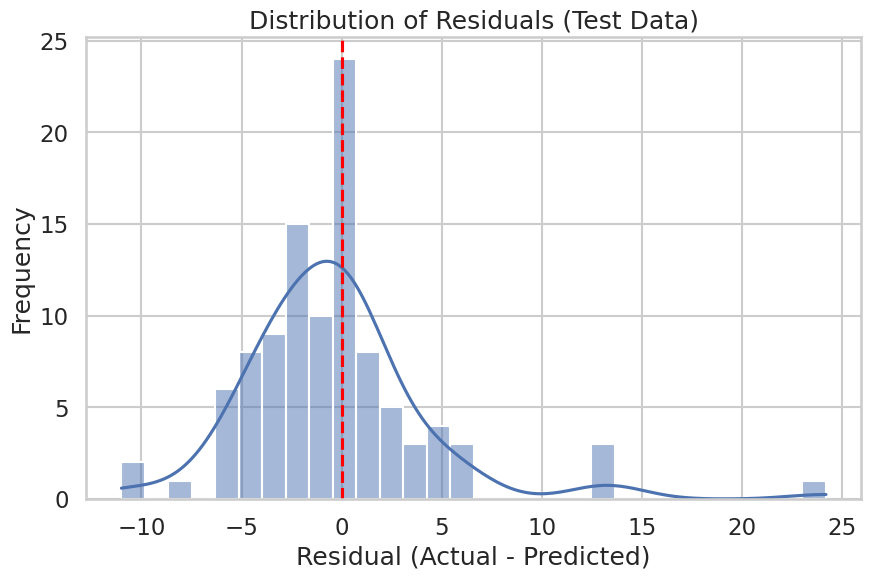

In [48]:
if 'model' in locals():
    # Plotting Residuals (on Test Data)
    # Residuals = Actual - Predicted
    residuals = y_test - y_pred_test
    
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title('Distribution of Residuals (Test Data)')
    plt.xlabel('Residual (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.axvline(0, color='red', linestyle='--')
    plt.show()
    
    # A good model has residuals normally distributed around 0.

### Step 9: Conclusion

We have successfully built, trained, and evaluated a linear regression model from scratch.

* **Model:** Our gradient descent-based model performs well, achieving a **Test R-squared of ~0.71**. This means our model can explain about 71% of the variance in housing prices on unseen data.
* **Hypothesis Testing:**
    * The **F-test** yielded a p-value very close to 0, allowing us to reject the null hypothesis and conclude that our model, as a whole, is statistically significant and has predictive power.
    * The **t-tests** showed that several features (like `LSTAT`, `RM`, `PTRATIO`, `DIS`, `NOX`) have very small p-values (< 0.05), indicating they are statistically significant predictors. Other features (like `CHAS`, `ZN`, `INDUS`, `AGE`) have high p-values, suggesting they are not strong linear predictors of `medv` *when all other features are present*.
* **Process:** We saw the importance of feature scaling (for gradient descent) and visualizing results (to confirm model convergence and check residuals).
* **Performance:** The Test MSE of ~29.4 indicates the average squared difference between our prediction and the actual price is about 29.4 (in $1000s squared).